In [36]:
import numpy as np
import os
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import decimate

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [110]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/dm_nanospheres/analysis_notebooks/../analysis_utils.py'>

In [37]:
## Calibration values for Sphere 20250103
c_mv = 8.263269630174246e-08
amp2kev = 7396.062147743912
sigma_p = 193.80085102332893  # keV/c

In [38]:

def gaus(x, x0, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-1 * (x - x0)**2 / (2 * sigma**2))

def search_expectation(x0, alpha, amp2kev, sig_amp):
    sigma = sig_amp * amp2kev
    bias = alpha * sigma

    first = bias * 0.5 * ( erf((bias - x0)/(np.sqrt(2) * sigma)) - erf((-1 * bias - x0)/(np.sqrt(2) * sigma)) )

    xx0 = np.linspace(bias, x0 + 5*sigma, 1000)
    second = np.trapz(gaus(xx0, x0, sigma) * np.abs(xx0), xx0, axis=0)

    xx1 = np.linspace(x0 - 5*sigma, -1 * bias, 1000)
    third = np.trapz(gaus(xx1, x0, sigma) * np.abs(xx1), xx1, axis=0)

    return (first + second + third) / amp2kev

In [39]:
def get_pulse_shape_template(sphere, voltage, amp2kev):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0) * amp2kev

    return pulse_shape_template

def get_normalized_template_all(sphere, voltages):
    """Peak-normalized template averaged over all pulses of different amplitudes"""
    waveform_normalized_all = []
    for voltage in voltages:
        pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
        pulse_shapes = pulse_shape_file['pulse_shape']

        pulse_shapes_normalized = np.empty_like(pulse_shapes)
        for i, pulse in enumerate(pulse_shapes):
            pulse_shapes_normalized[i] = pulse / np.max(pulse)

            if np.max(pulse_shapes_normalized[i] > 1.0):
                print(np.max(pulse_shapes_normalized[i]))

        waveform_normalized_all.append(pulse_shapes_normalized)

    waveform_normalized_all = np.concatenate(waveform_normalized_all, axis=0)
    pulse_shape_template = np.mean(np.asarray(waveform_normalized_all), axis=0)

    return pulse_shape_template

In [ ]:
## First derive the calibration factor for plotting
data_files = [r'/Volumes/LaCie/dm_data/sphere_20250103/20250114_1e-8mbar1e_10vp2p_0.hdf5']
c_mvs = utils.get_c_mv(data_files, [10], 93000*2*np.pi, passband=(91700, 94300), charge=1, n_chunk=60)

c_mv = np.mean(c_mvs)

## Calibration

In [ ]:
outfile_name = 'sphere_20250103_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 7158

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 176.79818534573002 keV/c
Averaged `amp2keV`: 7157.624533259538


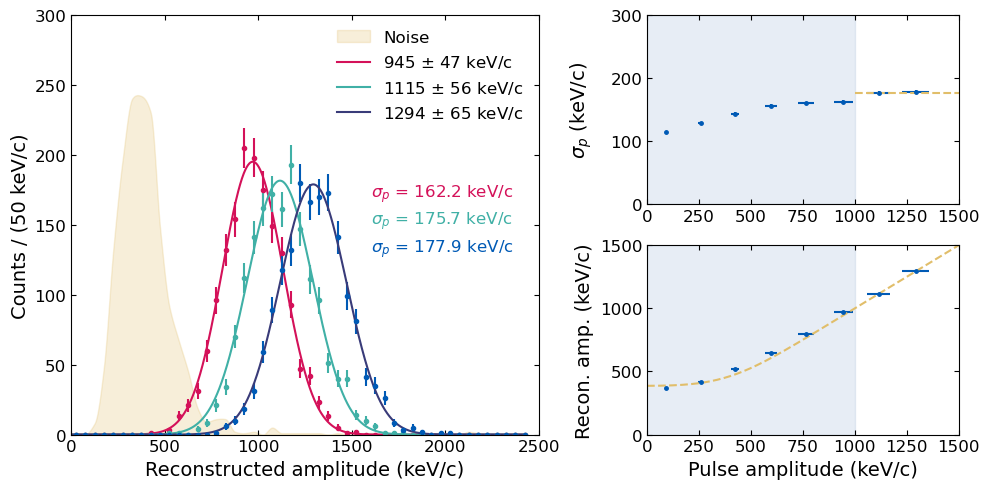

In [ ]:
xx = np.linspace(0, 1500, 500)
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[3])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

from scipy.interpolate import Akima1DInterpolator
xs = np.linspace(np.min(bcs[0]), np.max(bcs[0]), 500)
y_makima = Akima1DInterpolator(bcs[0], hh_noise, method="makima")(xs)

# ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')
ax.fill_between(xs*amp2kev_all, y_makima, color='#E1BE6A', alpha=0.25, label='Noise')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=fr'945 $\pm$ {945*0.05:.0f} keV/c', color='#D41159')

ax.errorbar(bcs[0]*amp2kev_all, hhs[6], yerr=np.sqrt(hhs[6]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[6]), label=fr'1115 $\pm$ {1115*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=fr'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.text(1600, 170, fr'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)
ax.text(1600, 150, fr'$\sigma_p$ = {gps[6][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(1600, 130, fr'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 300)

# Second plot fo resolution
ax = ax1

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

idx_fit = pulseamps > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(1000, 4000, 500)
ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')
ax.fill_betweenx(np.linspace(0, 300, 100), 0, 1000, color='#B0C4DE', alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
ax.set_ylabel(r'$\sigma_p$ (keV/c)')

# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# Fit for search bias
f_bias = lambda x, alpha: search_expectation(x, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all
popt_bias, pcov_bias = curve_fit(f_bias, pulseamps, amps*amp2kev_all, p0=[0.87], sigma=sig_p_avg/np.sqrt(n_pulses))

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.fill_betweenx(np.linspace(0, 1500, 100), 0, 1000, color='#B0C4DE', alpha=0.3)
xx = np.linspace(0, 4000, 500)
ax.plot(xx, f_bias(xx, *popt_bias), '--', color='#E1BE6A', 
             label=fr'$\sigma_{{p, 0}}$={popt_sig[-1]:.0f} keV/c\n$\sigma_b$ = {popt_sig[-1]*popt_bias[-1]:.0f} keV/c')

ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Pulse amplitude (keV/c)')
ax.set_ylabel(r'Recon. amp. (keV/c)')

fig.tight_layout()
fig.align_labels()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/impulse_calibration_sphere_20250103.pdf', dpi=600)

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')

In [100]:
outfile_name = 'sphere_20241202_calibration_unnormalized_amps.h5py'
out_dir = '/Users/yuhan/work/nanospheres/data/pulse_calibration_processed'

unnormalized_amps_all_flattened = []

fout = h5py.File(os.path.join(out_dir, outfile_name), 'r')
g = fout['processed_amplitudes']
for v in [2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20]:
    unnormalized_amps_all_flattened.append(g[f'unnormalized_amps_{v}v'][:])

unnormalized_amps_noise_flattened = g['unnormalized_amps_noise_5v'][:]

fout.close()

bins = np.arange(0, 2500, 50) / 7187.6

hhs, bcs, gps = utils.fit_amps_gaus(unnormalized_amps_all_flattened, bins=bins, noise=False, return_bins=False)
hh_noise, be_noise = np.histogram(unnormalized_amps_noise_flattened, bins=bins)

Fitted resolution: 171.44101566516954 keV/c
Averaged `amp2keV`: 7187.368332843102


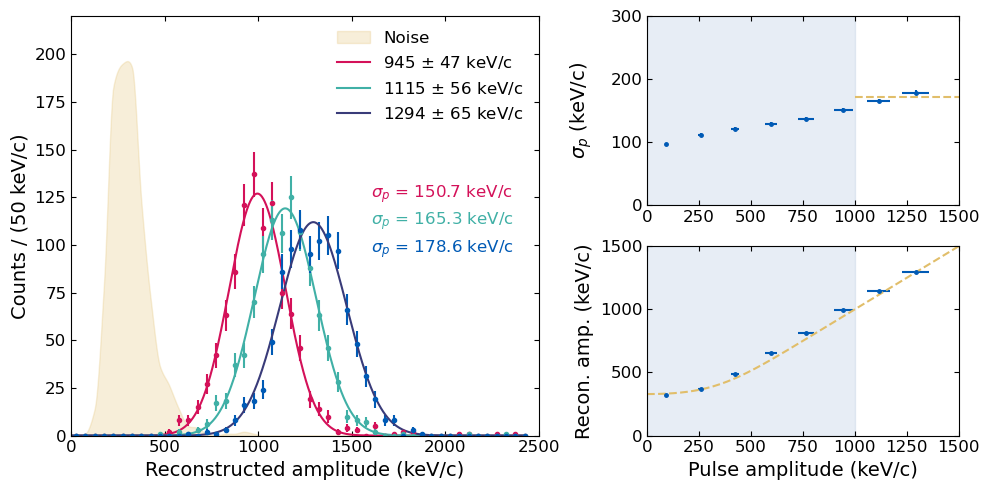

In [102]:
xx = np.linspace(0, 1500, 500)
pulseamps = np.asarray([92, 258, 423, 597, 765, 945, 1115, 1294])
pulseamps_err = pulseamps * 0.05
n_pulses = np.asarray([amps.size for amps in unnormalized_amps_all_flattened])

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(2, 2, width_ratios=[1.5, 1], height_ratios=[1, 1])
ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[1])
ax2 = fig.add_subplot(gs[3])

# First plot
ax = ax0
xx = np.linspace(0, np.max(bcs[0]), 1000)
amp2kev_all = 1294 / gps[7][1]

from scipy.interpolate import Akima1DInterpolator
xs = np.linspace(np.min(bcs[0]), np.max(bcs[0]), 500)
y_makima = Akima1DInterpolator(bcs[0], hh_noise, method="makima")(xs)

# ax.fill_between(bcs[0]*amp2kev_all, hh_noise, color='#E1BE6A', alpha=0.25, label='Noise')
ax.fill_between(xs*amp2kev_all, y_makima, color='#E1BE6A', alpha=0.25, label='Noise')

ax.errorbar(bcs[0]*amp2kev_all, hhs[5], yerr=np.sqrt(hhs[5]), fmt='.', color='#D41159')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[5]), label=fr'945 $\pm$ {945*0.05:.0f} keV/c', color='#D41159')

ax.errorbar(bcs[0]*amp2kev_all, hhs[6], yerr=np.sqrt(hhs[6]), fmt='.', color='#40B0A6')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[6]), label=fr'1115 $\pm$ {1115*0.05:.0f} keV/c', color='#40B0A6')

ax.errorbar(bcs[0]*amp2kev_all, hhs[7], yerr=np.sqrt(hhs[7]), fmt='.', color='#005AB5')
ax.plot(xx*amp2kev_all, utils.gauss(xx, *gps[7]), label=fr'1294 $\pm$ {1294*0.05:.0f} keV/c')

ax.text(1600, 170*22/30, fr'$\sigma_p$ = {gps[5][2]*amp2kev_all:.1f} keV/c', color='#D41159', fontsize=12)
ax.text(1600, 150*22/30, fr'$\sigma_p$ = {gps[6][2]*amp2kev_all:.1f} keV/c', color='#40B0A6', fontsize=12)
ax.text(1600, 130*22/30, fr'$\sigma_p$ = {gps[7][2]*amp2kev_all:.1f} keV/c', color='#005AB5', fontsize=12)

ax.legend(frameon=False, fontsize=12)
ax.set_xlabel(r'Reconstructed amplitude (keV/c)')
ax.set_ylabel(fr'Counts / ({(bcs[0][1] - bcs[0][0]) * amp2kev_all:.0f} keV/c)')

ax.set_xlim(0, 2500)
ax.set_ylim(0, 220)

# Second plot fo resolution
ax = ax1

sig_p_avg = np.asarray(gps).T[2] * amp2kev_all
ax.errorbar(pulseamps, sig_p_avg, yerr=sig_p_avg/np.sqrt(2 * (n_pulses-1)), xerr=pulseamps_err, 
            fmt='.', markersize=5, color='#005AB5')

idx_fit = pulseamps > 1000
f = lambda x, b: b
popt_sig, pcov_sig = curve_fit(f, pulseamps[idx_fit], sig_p_avg[idx_fit], p0=[200], sigma=sig_p_avg[idx_fit]/np.sqrt(2 * (n_pulses[idx_fit]-1)))
xx = np.linspace(1000, 4000, 500)
ax.plot(xx, np.full_like(xx, popt_sig[0]), '--', color='#E1BE6A')
ax.fill_betweenx(np.linspace(0, 300, 100), 0, 1000, color='#B0C4DE', alpha=0.3)

ax.set_ylim(0, 300)
ax.set_xlim(0, 1500)
ax.set_ylabel(r'$\sigma_p$ (keV/c)')

# Third plot for search bias
ax = ax2
amps = np.asarray(gps).T[1]
amps_std = np.asarray(gps).T[2]

# Fit for search bias
f_bias = lambda x, alpha: search_expectation(x, alpha, amp2kev_all, popt_sig[-1]/amp2kev_all) * amp2kev_all
popt_bias, pcov_bias = curve_fit(f_bias, pulseamps, amps*amp2kev_all, p0=[0.87], sigma=sig_p_avg/np.sqrt(n_pulses))

ax.errorbar(pulseamps, amps*amp2kev_all, yerr=amps_std*amp2kev_all/np.sqrt(n_pulses), xerr=pulseamps_err, fmt='.', markersize=5, color='#005AB5')
ax.fill_betweenx(np.linspace(0, 1500, 100), 0, 1000, color='#B0C4DE', alpha=0.3)
xx = np.linspace(0, 4000, 500)
ax.plot(xx, f_bias(xx, *popt_bias), '--', color='#E1BE6A', 
             label=fr'$\sigma_{{p, 0}}$={popt_sig[-1]:.0f} keV/c\n$\sigma_b$ = {popt_sig[-1]*popt_bias[-1]:.0f} keV/c')

ax.set_ylim(0, 1500)
ax.set_xlim(0, 1500)
ax.set_xlabel(r'Pulse amplitude (keV/c)')
ax.set_ylabel(r'Recon. amp. (keV/c)')

fig.tight_layout()
fig.align_labels()

# plt.savefig('/Users/yuhan/work/nanospheres/paper_plots/dm_nanospheres/impulse_calibration_sphere_20250103.pdf', dpi=600)

print(f'Fitted resolution: {popt_sig[-1]} keV/c')
print(f'Averaged `amp2keV`: {amp2kev_all}')

#### Average over calibration pulses to form template
Decided to use the averaged pulse shape of 20 V pulses (1294 keV) as the template for chi square test (and not including other amplitudes) because the large pulses are least affected by noise.

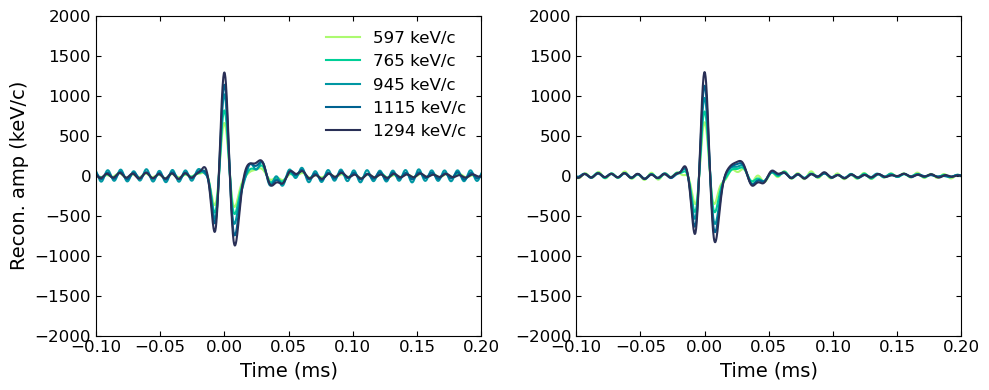

In [114]:
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70']
pulse_amps = [597, 765, 945, 1115, 1294]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

dtt = 2e-7
for i, v in enumerate([10, 12.5, 15, 17.5, 20]):
    axes[0].plot(np.arange(-1500, 1500, 1)*dtt/1e-3, get_pulse_shape_template('sphere_20241202', v, 7187.368332843102), label=f'{pulse_amps[i]} keV/c', color=colors[4-i])
    axes[1].plot(np.arange(-1500, 1500, 1)*dtt/1e-3, get_pulse_shape_template('sphere_20250103', v, 7157.624533259538), label=f'{pulse_amps[i]} keV/c', color=colors[4-i])

for ax in axes:
    ax.set_xlim(-0.1, 0.2)
    ax.set_ylim(-2000, 2000)
    ax.set_xlabel('Time (ms)')

axes[0].set_ylabel('Recon. amp (keV/c)')
axes[0].legend(frameon=False)

fig.tight_layout()

#### Example calibration events

In [104]:
## Read charging data
dir_filament = r'/Volumes/LaCie/pulse_calibration/discharging/filament_discharging'
dir_uv = r'/Volumes/LaCie/pulse_calibration/discharging/uv_discharging'

dtt_charging = 0.0001
_ee_filament = []
for i in range(1, 4):
    file_name = f'filament_discharging_{i}.csv'
    data = np.genfromtxt(os.path.join(dir_filament, file_name), delimiter=',', skip_header=2).T
    
    _ee_filament.append(data[-1])

_ee_uv = []
for i in range(1, 17):
    if i < 10:
        file_name = f'uv_discharging_0{i}.csv'
    else:
        file_name = f'uv_discharging_{i}.csv'
    data = np.genfromtxt(os.path.join(dir_uv, file_name), delimiter=',', skip_header=2).T
    
    _ee_uv.append(data[-1])

ee_filament = np.concatenate(_ee_filament)
ee_uv = np.concatenate(_ee_uv)

In [105]:
data_file = r'/Volumes/LaCie/pulse_calibration/sphere_20250103/20250117_8e_alignment1_8e-9mbar_0/20250117_dg_8e_200ns_20v_0.hdf5'

dtt, nn = utils.load_timestreams(data_file, ['D', 'G'])

fs = int(np.ceil(1/dtt))
zz, dd = nn[0], nn[1]
zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

drive_indices = utils.get_pulse_idx(dd, 0.5, True)


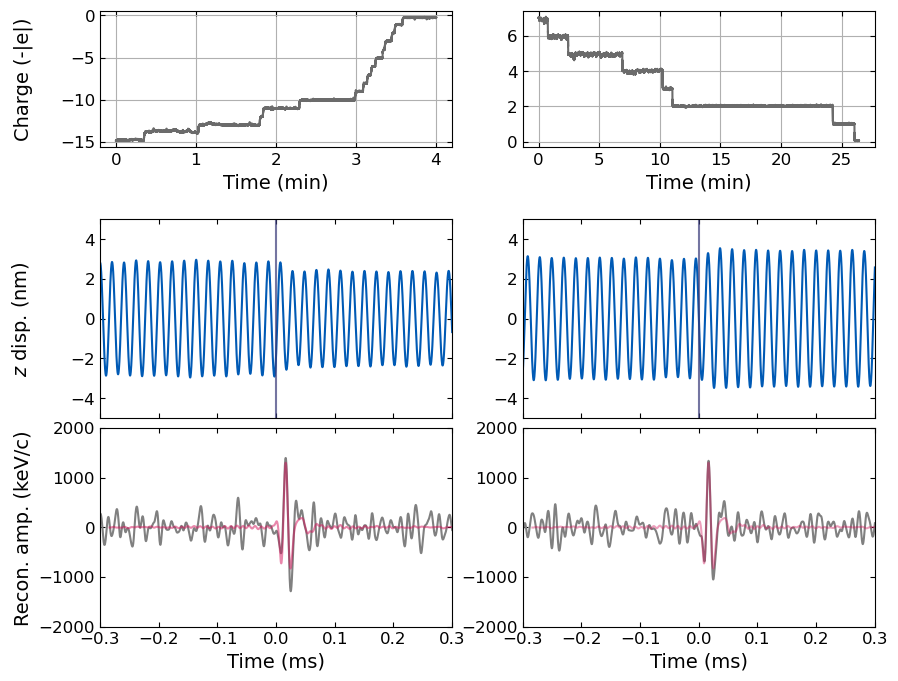

In [113]:
fig = plt.figure(figsize=(10, 8))

gs1 = GridSpec(3, 2)
gs1.update(hspace=0.75)

ax0, ax1 = plt.subplot(gs1[0, 0]), plt.subplot(gs1[0, 1])

gs2 = GridSpec(3, 2)
gs2.update(hspace=0.05)

ax2, ax3 = plt.subplot(gs2[1, 0]), plt.subplot(gs2[1, 1])
ax4, ax5 = plt.subplot(gs2[2, 0]), plt.subplot(gs2[2, 1])

axes=np.asarray([[ax0, ax1], [ax2, ax3], [ax4, ax5]])

## Plot charging data
axes[0, 0].plot(np.arange(0, dtt_charging*ee_filament.size, dtt_charging)/60, -1*ee_filament/0.103, color='#6B6B6B')
axes[0, 1].plot(np.arange(0, dtt_charging*ee_uv.size, dtt_charging)/60, ee_uv/0.376, color='#6B6B6B')

## Plot calibration waveform
pulse_shape_template = get_pulse_shape_template('sphere_20250103', 20, 7157.624533259538)

window, f, f_lp, amp = utils.recon_pulse(drive_indices[2], dtt, zz_bp, dd, 50000, 50000, 250, 20)
pulse_idx_in_win = np.argmin(np.abs(np.abs(f_lp/1e9) - amp))
tt_template = np.arange(pulse_idx_in_win-50000-1500, pulse_idx_in_win-50000+1500) * dtt

window_size = np.sum(window)
# Offset the applied pulse to center
axes[1, 0].plot(np.arange(0, dtt*window_size, dtt)/1e-3 - 10, zz_bp[window] * c_mv / 1e-9, color='#005AB5')
axes[1, 0].vlines(0, -5, 5, alpha=0.7)
axes[2, 0].plot(np.arange(0, dtt*window_size, dtt)/1e-3 - 10, f_lp*amp2kev/1e9, color='grey')
axes[2, 0].plot(tt_template/1e-3, pulse_shape_template, color='#D41159', alpha=0.5)

window_1, f_1, f_lp_1, amp_1 = utils.recon_pulse(drive_indices[4], dtt, zz_bp, dd, 50000, 50000, 250, 20)
pulse_idx_in_win_1 = np.argmin(np.abs(np.abs(f_lp_1/1e9) - amp_1))
tt_template_1 = np.arange(pulse_idx_in_win_1-50000-1500, pulse_idx_in_win_1-50000+1500) * dtt

window_size_1 = np.sum(window_1)
axes[1, 1].plot(np.arange(0, dtt*window_size_1, dtt)/1e-3 - 10, zz_bp[window_1] * c_mv / 1e-9, color='#005AB5')
axes[1, 1].vlines(0, -5, 5, alpha=0.7)
axes[2, 1].plot(np.arange(0, dtt*window_size_1, dtt)/1e-3 - 10, f_lp_1*amp2kev/1e9, color='grey')
axes[2, 1].plot(tt_template_1/1e-3, pulse_shape_template, color='#D41159', alpha=0.4)

axes[0, 0].set_ylabel('Charge (-|e|)')
axes[1, 0].set_ylabel('$z$ disp. (nm)')
axes[2, 0].set_ylabel('Recon. amp. (keV/c)')

for i in range(0, 2):
    axes[0, i].set_xlabel('Time (min)')
    axes[0, i].grid()

    axes[1, i].set_xlim(-0.3, 0.3)
    axes[2, i].set_xlim(-0.3, 0.3)

    axes[1, i].set_ylim(-5, 5)
    axes[2, i].set_ylim(-2000, 2000)

    axes[1, i].set_xticklabels([])
    axes[2, i].set_xlabel('Time (ms)')

fig.align_labels()


In [128]:
def get_normalized_template(sphere, voltage, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

    # Take the central 0.2 ms around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [129]:

def get_chisquares(sphere, voltage, normalized_template, sigma, downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']

    chisquares = np.empty(pulse_shapes.shape[0])
    chisquares_neg = np.empty(pulse_shapes.shape[0])
    for i, pulse in enumerate(pulse_shapes):
        pulse_test = pulse[1000:2000]
        if downsampled:
            pulse_test = decimate(pulse_test, 10)

        pulse_test_neg = -1 * pulse_test

        amp = np.max(pulse_test)
        template_scaled = normalized_template * amp

        chisquares[i] = np.sum( ((pulse_test - template_scaled)/sigma)**2 )
        chisquares_neg[i] = np.sum( ((pulse_test_neg - template_scaled)/sigma)**2 )

    return chisquares, chisquares_neg

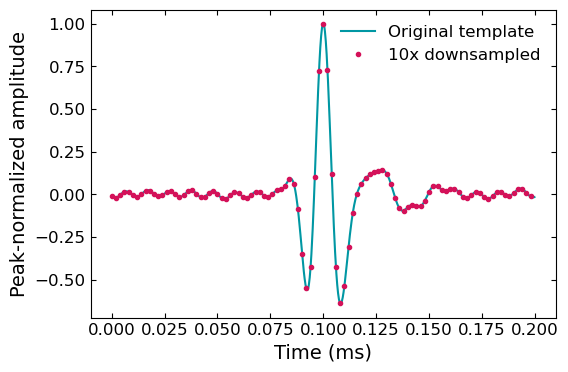

In [ ]:
colors = ['#292f56', '#006290', '#0097a3', '#00cf97', '#acfa70']

normalized_template = get_normalized_template('sphere_20250103', 20, False)
normalized_template_downsampled = get_normalized_template('sphere_20250103', 20, True)

dtt = 2e-7 # 200 ns sampling interval for the calibration data
tt = np.arange(0, 1000, 1)*dtt/1e-3
tt1 = np.arange(0, 100, 1)*dtt*10/1e-3

plt.figure(figsize=(6, 4))
plt.plot(tt, normalized_template, label='Original template', color=colors[2])
plt.plot(tt1, normalized_template_downsampled, '.', label='10x downsampled', color='#D41159')
plt.xlabel('Time (ms)')
plt.ylabel('Peak-normalized amplitude')
plt.legend(frameon=False)

## Calculate the $\chi^2$ of calibration pulses
The templates and all pulses are downsampled by 10x to match the sampling rate of the actual DM data

In [118]:
sphere = 'sphere_20250103'
voltages = [10, 12.5, 15, 17.5, 20]

chisquares_all = []
chisquares_neg_all = []
for i, v in enumerate(voltages):
    cc = get_chisquares(sphere, v, normalized_template_downsampled, sigma_p/amp2kev, downsampled=True)
    chisquares_all.append(cc[0])
    chisquares_neg_all.append(cc[1])


In [123]:
# Calculate chi square for noise
sigma = sigma_p / amp2kev

chisquares_noise = np.empty(1600)
for i in range(1600):
    noise = np.random.normal(scale=sigma_p/amp2kev, size=100)
    amp = noise[50]
    template_scaled = normalized_template_downsampled * amp

    chisquares_noise[i] = np.sum( ((noise - template_scaled)/sigma)**2 )

Threshold = 200
Fraction rejected (597 keV/c): 0.043859649122807015
Fraction rejected (765 keV/c): 0.02127659574468085
Fraction rejected (945 keV/c): 0.026959247648902823
Fraction rejected (1115 keV/c): 0.028125
Fraction rejected (1294 keV/c): 0.041353383458646614
Fraction rejected (averaged): 0.035 $\pm$ 0.007
Fraction rejected (noise): 0.0


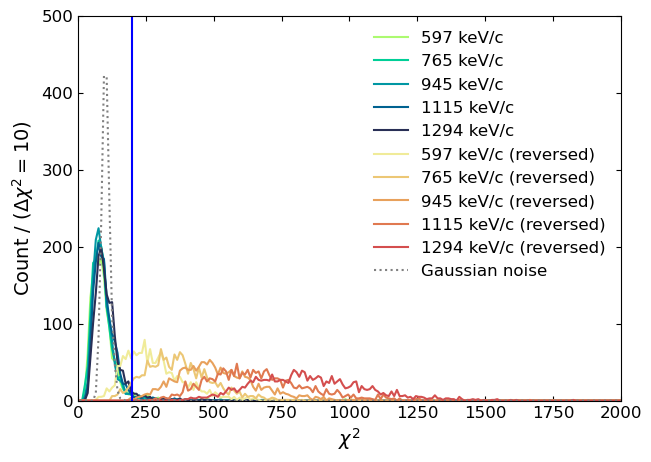

In [ ]:
colors_warm = ['#d44e4e', '#e07950', '#e8a15c', '#ecc775', '#f0eb99']
pulse_amps = [597, 765, 945, 1115, 1294]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

bins = np.arange(0, 2500, 10)
for i, chisquares in enumerate(chisquares_all):
    hh, be = np.histogram(chisquares, bins=bins)
    bc = 0.5 * (be[:-1] + be[1:])
    ax.plot(bc, hh, label=fr'{pulse_amps[i]} keV/c', color=colors[4-i])

for i, chisquares in enumerate(chisquares_neg_all):
    hh_n, be_n = np.histogram(chisquares_neg_all[i], bins=bins)
    bc_n = 0.5 * (be_n[:-1] + be_n[1:])

    ax.plot(bc_n, hh_n, '-', label=fr'{pulse_amps[i]} keV/c (reversed)', color=colors_warm[4-i])

    if i == 4:
        hh_noise, be_noise = np.histogram(chisquares_noise, bins=bins)
        bc_noise = 0.5 * (be_noise[:-1] + be_noise[1:])
        ax.plot(bc_noise, hh_noise, ':',label=f'Gaussian noise', color='grey')

ax.vlines(200, 0, 1200, color='b')

ax.set_ylabel(r'Count / ($\Delta \chi^2=10$)')
ax.set_xlabel(r'$\chi^2$')

ax.set_xlim(0, 2000)
ax.set_ylim(0, 500)
ax.legend(frameon=False)

thr = 200
print(f'Threshold = {thr}')

fractions = np.empty(5)
for i, chisquares in enumerate(chisquares_all):
    fractions[i] = (np.sum(chisquares > thr) / chisquares.size)
    print(f'Fraction rejected ({pulse_amps[i]} keV/c): {np.sum(chisquares > thr) / chisquares.size}')

print(fr'Fraction rejected (averaged): {np.mean(fractions[-2:]):.3f} $\pm$ {np.std(fractions[-2:]):.3f}')
print(f'Fraction rejected (noise): {np.sum(chisquares_noise > thr) / chisquares_noise.size}')

## Reconstruction

In [11]:
def read_sphere_data(sphere):
    # data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
    data_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all_w_nocut.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']

        hists, n_windows, scalings, rates, rate_errs = [], [], [], [], []
        for i in range(4):
            hists.append(g[f'hist_{i}'][:])
            n_windows.append(g[f'hist_{i}'].attrs['n_windows'])
            scalings.append(g[f'hist_{i}'].attrs['scaling'])

            rates.append(g[f'rate_hist_{i}'][:])
            rate_errs.append(g[f'rate_hist_err_{i}'][:])
        bc = g['bc'][:]

        fout.close()

    return bc, hists, n_windows, scalings, rates, rate_errs
    

In [12]:
bc_0, hists_0, n_windows_0, scalings_0, rates_0, rate_errs_0 = read_sphere_data('sphere_20241202')
bc_1, hists_1, n_windows_1, scalings_1, rates_1, rate_errs_1 = read_sphere_data('sphere_20250103')

In [48]:
print(f'Cut percentage (Sphere 20241202; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_0)) / n_windows_0[0] * 100}')
print(f'Cut percentage (Sphere 20250103; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_1)) / n_windows_1[0] * 100}')

Cut percentage (Sphere 20241202; DQ, NL, PS): [7.04848477e+00 6.40000539e-01 5.58130344e-03]
Cut percentage (Sphere 20250103; DQ, NL, PS): [3.27918567 1.41467842 0.011878  ]


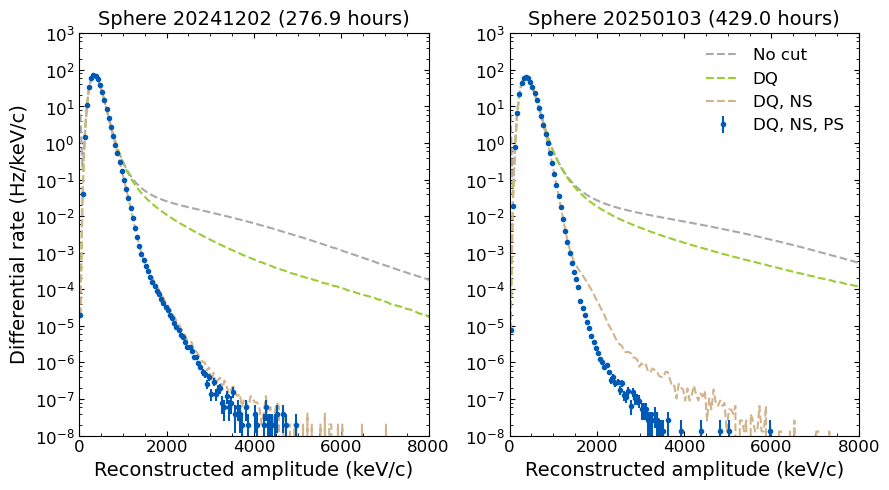

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

ax = axes[0]
ax.plot(bc_0, rates_0[0], '--', alpha=1, color='darkgrey')
ax.plot(bc_0, rates_0[1], '--', alpha=1, color='yellowgreen')
ax.plot(bc_0, rates_0[2], '--', alpha=1, color='tan')
ax.errorbar(bc_0, rates_0[3], yerr=rate_errs_0[3], fmt='.', color='#005AB5', alpha=1)

ax.set_title('Sphere 20241202 (276.9 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential rate (Hz/keV/c)')

ax = axes[1]
ax.plot(bc_1, rates_1[0], '--', alpha=1, label='No cut', color='darkgrey')
ax.plot(bc_1, rates_1[1], '--', alpha=1, label='DQ', color='yellowgreen')
ax.plot(bc_1, rates_1[2], '--', alpha=1, label='DQ, NS', color='tan')
ax.errorbar(bc_1, rates_1[3], yerr=rate_errs_1[3], fmt='.', color='#005AB5', alpha=1, label='DQ, NS, PS')

ax.set_title('Sphere 20250103 (429.0 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.legend(frameon=False)

for ax in axes:
    ax.set_yscale('log')
    # ax.set_xscale('log')

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

    ax.set_yticks(np.logspace(-8, 3, 12))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()

## Example events rejected by datacuts

In [20]:
file = r'/Users/yuhan/work/nanospheres/data/pulse_calibration_processed/sphere_20250103_calibration_unnormalized_amps.h5py'
f = h5py.File(file, "r")

In [25]:
f['processed_amplitudes']['unnormalized_amps_20v'][:] * amp2kev

array([1488.1577597 , 1167.86032953, 1128.16655798, 1359.93588964,
       1228.61307941, 1377.31035179, 1406.40945641, 1295.65256935,
       1202.01993989, 1661.9242124 , 1215.09039699, 1400.44556685,
       1481.40539272, 1309.47448293, 1448.5142239 , 1074.66633697,
       1196.91353869, 1365.04386067, 1192.1806379 , 2108.18268557,
       1397.0857572 , 1200.78229664, 1306.1947478 , 1365.51747934,
       1537.5221124 , 1406.11524941, 1291.99849353, 1393.28257805,
       1414.27177117, 1575.11472406, 1598.46431996, 1634.60494775,
       1230.52606994, 1205.30848104, 1379.63318872, 1279.25808814,
       1331.33163413, 1725.28581934, 1111.75396729, 1514.24329885,
       1539.77161744, 1127.95497205, 1351.80638676, 1313.84638798,
       1183.8816815 , 1210.73004584, 1434.52226406, 1426.33752025,
       1286.71152686, 1351.94396583, 1101.84435242, 1253.6443218 ,
       1227.88843472, 1398.53719545, 1376.27815717, 1457.78119033,
       1220.48910009, 1411.75945031, 1267.16734554, 1690.70227

In [26]:
f.close()